In [54]:
import jax
import jax.numpy as jnp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from jax.example_libraries.optimizers import adam as optimizer
# jax.config.update('jax_platform_name', 'cpu')
# jax.config.update('jax_disable_jit', True)

In [65]:
MB = 2 ** 10
NN_SHAPES = jnp.array([64, 64, 64])
SCALE = 0.1
INIT_KEYS = jax.random.split(jax.random.PRNGKey(1), 8)

BETA = 0.9
MAX_AGE = 2.
OBJECTIVE_FN = lambda x, t: jax.lax.select(t == 2., 
                                           jnp.array([jnp.log(x), x]), 
                                           jax.lax.select(t == 1., 
                                                          jnp.array([jnp.log(x / (1 + BETA)) + BETA * jnp.log((BETA * x) / (1 + BETA)), (x / (1 + BETA))]), 
                                                          jnp.array([(1 + BETA + BETA**2) * jnp.log(x) - (1 + BETA + BETA **2) * jnp.log(1 + BETA + BETA**2) + BETA * (1 + 2 * BETA) * jnp.log(BETA),
                                                                     x / (1 + BETA + BETA**2)])))

In [63]:
w0 = SCALE * jax.random.normal(INIT_KEYS[0], shape=(2, NN_SHAPES[0]))
w1 = SCALE * jax.random.normal(INIT_KEYS[1], shape=(NN_SHAPES[0], NN_SHAPES[1]))
w2 = SCALE * jax.random.normal(INIT_KEYS[2], shape=(NN_SHAPES[1] + 2, NN_SHAPES[2]))
wf = SCALE * jax.random.normal(INIT_KEYS[3], shape=(NN_SHAPES[2],))
b0 = SCALE * jax.random.normal(INIT_KEYS[4], shape=(1, NN_SHAPES[0]))
b1 = SCALE * jax.random.normal(INIT_KEYS[5], shape=(1, NN_SHAPES[1]))
b2 = SCALE * jax.random.normal(INIT_KEYS[6], shape=(1, NN_SHAPES[2]))
bf = SCALE * jax.random.normal(INIT_KEYS[7], shape=(1,))
params0 = {'w0': w0, 'w1': w1, 'vw2': w2, 'cw2': w2, 'vwf': wf, 'cwf': wf, 
           'b0': b0, 'b1': b1, 'vb2': b2, 'cb2': b2, 'vbf': bf, 'cbf': bf}

In [57]:
@jax.jit
def linear(X, w, b):
    return jnp.dot(X, w) + b


@jax.jit
def relu(X, w, b):
    return jnp.maximum(linear(X, w, b), 0)


@jax.jit
def neural_network(params, x, t):
    l0 = jnp.concatenate((x[jnp.newaxis], t[jnp.newaxis]))
    l1 = relu(l0, params['w0'], params['b0'])
    l2 = jnp.squeeze(relu(l1, params['w1'], params['b1']))
    
    vl3 = relu(jnp.concatenate((l0, l2)), params['vw2'], params['vb2'])
    vu = linear(vl3, params['vwf'], params['vbf'])
    v = jnp.select(t[jnp.newaxis] > MAX_AGE, jnp.zeros(1), vu)
    
    cl3 = relu(jnp.concatenate((l0, l2)), params['cw2'], params['cb2'])
    cu = x * jax.nn.tanh(linear(cl3, params['cwf'], params['cbf']) / 1000)
    c = jnp.select(t[jnp.newaxis] >= MAX_AGE, x[jnp.newaxis], cu)
    
    return jnp.concatenate((v, c))


@jax.jit
def loss(params, x, t):
    v0, c0 = neural_network(params, x, t)
    v1, c1 = neural_network(params, x - c0, t + 1)
    
    live_next = (t < MAX_AGE)
    loss_euler = jax.lax.select(live_next, (c1 - (BETA * c0)), 0.)
    loss_bellman = (jnp.log(c0) + BETA * v1) - v0
    
    return jnp.array([10 * loss_euler, loss_bellman])


@jax.jit
def batch_loss(params, xs, ts):
    losses = jax.vmap(loss, in_axes=(None, 0, 0))(params, xs, ts)
    return jnp.mean(jnp.sum(losses**2, axis=1))

In [58]:
def training_loop(X, T, opt_state, opt_update, get_params, max_iter=1000):
    j = 0
    key = jax.random.PRNGKey(1)
    keys = jax.random.split(key, max_iter)

    while j < max_iter:
        key = keys[j]
        sample = jax.random.choice(key, jnp.arange(X.shape[0]), (2, MB))

        val_loss, grad = jax.value_and_grad(batch_loss)(get_params(opt_state), X[sample[0]], T[sample[1]])
        opt_state = opt_update(j, grad, opt_state)
        j += 1
        if j % 100 == 0:
            print(f'Iteration: {j}\tLoss: {val_loss}')
            
    return opt_state

In [59]:
opt_init, opt_update, get_params = optimizer(step_size=1e-1)
opt_state = opt_init(params0)
X = jnp.linspace(1e-5, 1., 1000)
T = jnp.concatenate((jnp.zeros(333), jnp.ones(333), 2 * jnp.ones(334)))

opt_state = training_loop(X, T, opt_state, opt_update, get_params, max_iter=2000)

Iteration: 100	Loss: 0.3641015291213989
Iteration: 200	Loss: 0.3182617425918579
Iteration: 300	Loss: 0.1353028565645218
Iteration: 400	Loss: 0.28369802236557007
Iteration: 500	Loss: 0.08175203204154968
Iteration: 600	Loss: 0.029973134398460388
Iteration: 700	Loss: 0.01759202778339386
Iteration: 800	Loss: 0.02032923698425293
Iteration: 900	Loss: 0.10097852349281311
Iteration: 1000	Loss: 0.017260519787669182
Iteration: 1100	Loss: 0.050758615136146545
Iteration: 1200	Loss: 0.07728424668312073
Iteration: 1300	Loss: 0.00503517733886838
Iteration: 1400	Loss: 0.11281169950962067
Iteration: 1500	Loss: 0.026776142418384552
Iteration: 1600	Loss: 0.08253571391105652
Iteration: 1700	Loss: 0.02566077932715416
Iteration: 1800	Loss: 0.027485549449920654
Iteration: 1900	Loss: 0.12590792775154114
Iteration: 2000	Loss: 0.18890812993049622


<AxesSubplot:xlabel='0'>

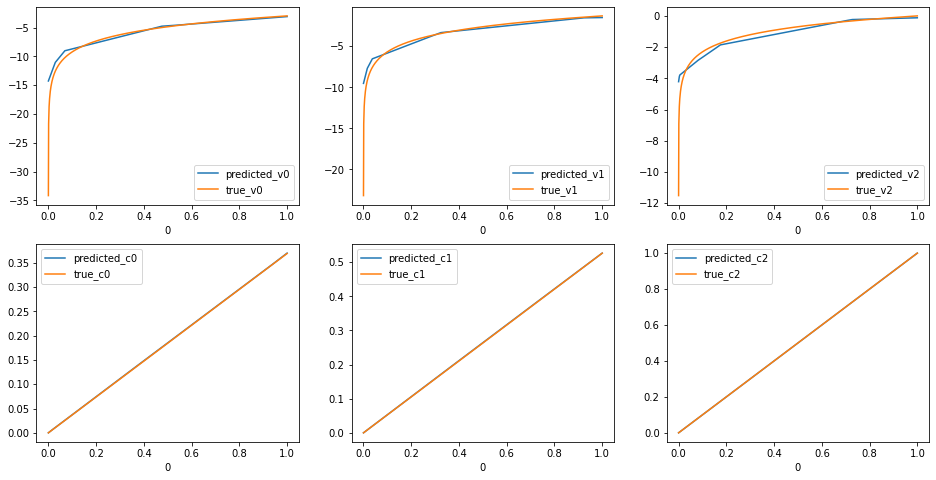

In [66]:
params = get_params(opt_state)
init0 = jax.vmap(neural_network, in_axes=(None, 0, None))(params0, X, 0.)
pred0 = jax.vmap(neural_network, in_axes=(None, 0, None))(params, X, 0.)
true0 = jax.vmap(OBJECTIVE_FN, in_axes=(0, None))(X, 0.)

init1 = jax.vmap(neural_network, in_axes=(None, 0, None))(params0, X, 1.)
pred1 = jax.vmap(neural_network, in_axes=(None, 0, None))(params, X, 1.)
true1 = jax.vmap(OBJECTIVE_FN, in_axes=(0, None))(X, 1.)

init2 = jax.vmap(neural_network, in_axes=(None, 0, None))(params0, X, 2.)
pred2 = jax.vmap(neural_network, in_axes=(None, 0, None))(params, X, 2.)
true2 = jax.vmap(OBJECTIVE_FN, in_axes=(0, None))(X, 2.)

df = pd.DataFrame(jnp.concatenate((X.reshape(-1, 1), 
                                   init0, pred0, true0, 
                                   init1, pred1, true1,
                                   init2, pred2, true2), 
                                  axis=1)).set_index(0)
df.columns = ['initial_v0', 'initial_c0', 'predicted_v0', 'predicted_c0', 'true_v0', 'true_c0',
              'initial_v1', 'initial_c1', 'predicted_v1', 'predicted_c1', 'true_v1', 'true_c1',
              'initial_v2', 'initial_c2', 'predicted_v2', 'predicted_c2', 'true_v2', 'true_c2']

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
df.plot(y=['predicted_v0', 'true_v0'], ax=axes.flatten()[0])
df.plot(y=['predicted_v1', 'true_v1'], ax=axes.flatten()[1])
df.plot(y=['predicted_v2', 'true_v2'], ax=axes.flatten()[2])
df.plot(y=['predicted_c0', 'true_c0'], ax=axes.flatten()[3])
df.plot(y=['predicted_c1', 'true_c1'], ax=axes.flatten()[4])
df.plot(y=['predicted_c2', 'true_c2'], ax=axes.flatten()[5])

In [67]:
all_X = jnp.concatenate((jnp.linspace(1e-5, 1., 1000), jnp.linspace(1e-5, 1., 1000)))
all_T = jnp.concatenate((jnp.zeros(1000), jnp.ones(1000)))

In [68]:
batch_loss(params, all_X[1000:], all_T[1000:])

DeviceArray(0.06996854, dtype=float32)

In [69]:
batch_loss(params, all_X[:1000], all_T[:1000])

DeviceArray(0.06829776, dtype=float32)

In [31]:
opt_init, opt_update, get_params = optimizer(step_size=1e-2)
opt_state = opt_init(get_params(opt_state))

opt_state = training_loop(X, T, opt_state, opt_update, get_params, max_iter=10000)

Iteration: 100	Loss: 0.14354537427425385
Iteration: 200	Loss: 0.19768573343753815
Iteration: 300	Loss: 0.14182737469673157
Iteration: 400	Loss: 0.18419164419174194
Iteration: 500	Loss: 0.1484564244747162
Iteration: 600	Loss: 0.17621402442455292
Iteration: 700	Loss: 0.16930121183395386
Iteration: 800	Loss: 0.13100865483283997
Iteration: 900	Loss: 0.17562799155712128
Iteration: 1000	Loss: 0.15183502435684204
Iteration: 1100	Loss: 0.16562709212303162
Iteration: 1200	Loss: 0.15143842995166779
Iteration: 1300	Loss: 0.1667408049106598
Iteration: 1400	Loss: 0.15945351123809814
Iteration: 1500	Loss: 0.17186430096626282
Iteration: 1600	Loss: 0.17536942660808563
Iteration: 1700	Loss: 0.15992286801338196
Iteration: 1800	Loss: 0.1471240222454071
Iteration: 1900	Loss: 0.1484469175338745
Iteration: 2000	Loss: 0.16191843152046204
Iteration: 2100	Loss: 0.15432840585708618
Iteration: 2200	Loss: 0.15172016620635986
Iteration: 2300	Loss: 0.1622915267944336
Iteration: 2400	Loss: 0.1369922012090683
Iterati